###Import

In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.8 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.

In [2]:
import os
from datasets import Dataset, DatasetDict, Image
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

###Utils

In [3]:
# Creating mapping between id and label
id2label = {0: 'sky',
            1:'building',
            2:'pole',
            3: 'road',
            4:'pavement',
            5: 'tree',
            6: 'signsymbol',
            7: 'fence',
            8: 'car',
            9: 'pedestrian',
            10: 'bicyclist',
            11: 'unlabelled'}
with open('id2label.json', 'w') as fp:
    json.dump(id2label, fp)

def plot_segmentation_map(segmentation_map):

    n_classes = len(id2label)
    cmap = plt.get_cmap('tab20', n_classes)
    norm = mcolors.BoundaryNorm(np.arange(n_classes + 1) - 0.5, n_classes)

    plt.figure(figsize=(10, 10))
    plt.imshow(segmentation_map, cmap=cmap, norm=norm)

    cbar = plt.colorbar(ticks=np.arange(n_classes))
    cbar.ax.set_yticklabels([id2label[i] for i in range(n_classes)])

    plt.title("Segmentation Map")
    plt.show()


###Download dataset
CamVid Image Segmentation dataset. 360x480 RGB street scenes images.

In [4]:
DATA_DIR = './data/CamVid/'

# load repo with data if it is not exists
if not os.path.exists(DATA_DIR):
    print('Loading data...')
    os.system('git clone https://github.com/alexgkendall/SegNet-Tutorial ./data')
    print('Done!')

Loading data...
Done!


In [8]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

###Creating a DatasetDict
The DatasetDict dataset will be used to create a PyTorch dataset to be used in the fine-tuning process.

In [9]:
def create_dataset(image_paths, label_paths):
  dataset = Dataset.from_dict({"image": sorted(image_paths),
                                "label": sorted(label_paths)})
  dataset = dataset.cast_column("image", Image())
  dataset = dataset.cast_column("label", Image())

  return dataset


In [35]:
train_image_paths = os.listdir(x_train_dir)
train_image_paths = [os.path.join(x_train_dir, file_name) for file_name in train_image_paths]
train_label_paths = os.listdir(y_train_dir)
train_label_paths = [os.path.join(y_train_dir, file_name) for file_name in train_label_paths]

val_image_paths = os.listdir(x_valid_dir)
val_image_paths = [os.path.join(x_valid_dir, file_name) for file_name in val_image_paths]
val_label_paths = os.listdir(y_valid_dir)
val_label_paths = [os.path.join(y_valid_dir, file_name) for file_name in val_label_paths]

test_image_paths = os.listdir(x_test_dir)
test_image_paths = [os.path.join(x_test_dir, file_name) for file_name in test_image_paths]
test_label_paths = os.listdir(y_test_dir)
test_label_paths = [os.path.join(y_test_dir, file_name) for file_name in test_label_paths]

train_ds = create_dataset(train_image_paths, train_label_paths)
val_ds = create_dataset(val_image_paths, val_label_paths)
test_ds = create_dataset(test_image_paths, test_label_paths)

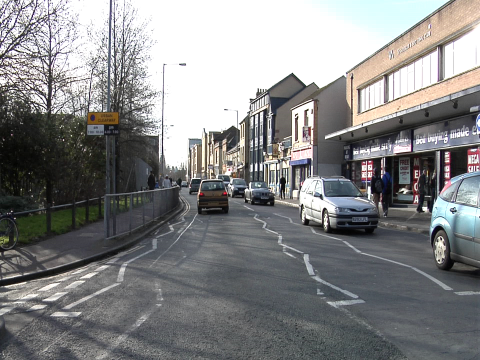

In [36]:
example = train_ds[200]
example['image']

array([[5, 5, 5, ..., 1, 1, 1],
       [5, 5, 5, ..., 1, 1, 1],
       [5, 5, 5, ..., 1, 1, 1],
       ...,
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3]], dtype=uint8)
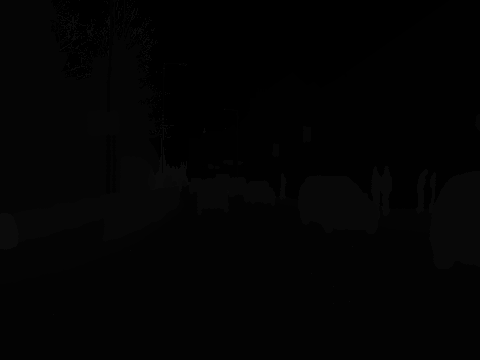

In [37]:
# An exemple of segmentation map
segmentation_map = np.array(example['label'])
segmentation_map

In [38]:
np.unique(segmentation_map)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=uint8)

In [39]:
# List of labels present in the image
labels = [id2label[label] for label in np.unique(segmentation_map)]
print(labels)

['sky', 'building', 'pole', 'road', 'pavement', 'tree', 'signsymbol', 'fence', 'car', 'pedestrian', 'bicyclist', 'unlabelled']


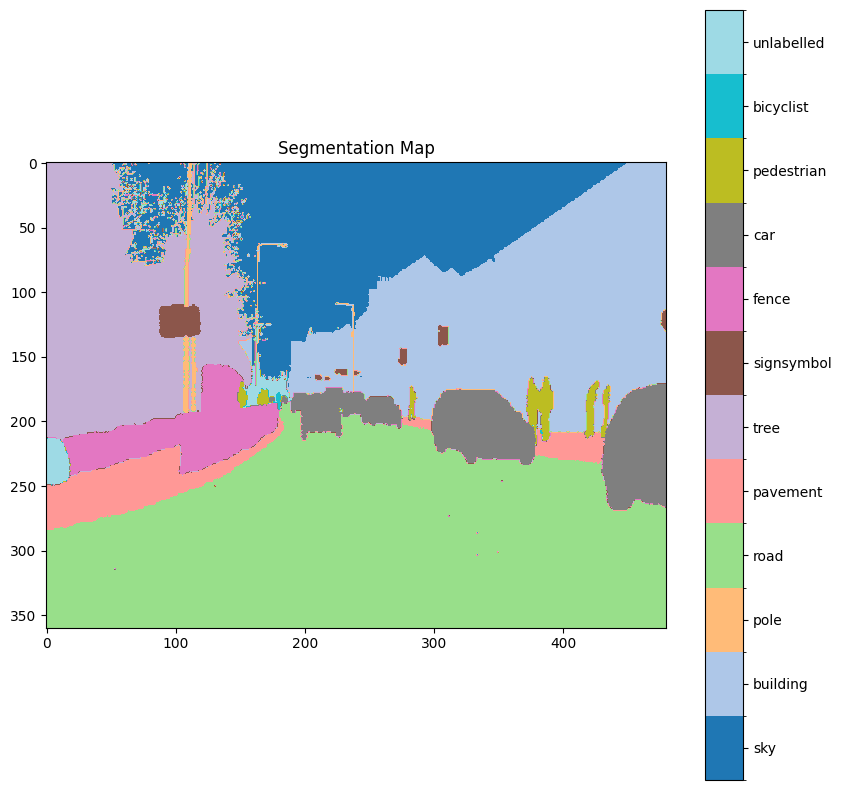

In [40]:
# Visualizing the segmentation map
plot_segmentation_map(segmentation_map)

In [43]:
img = example['image']

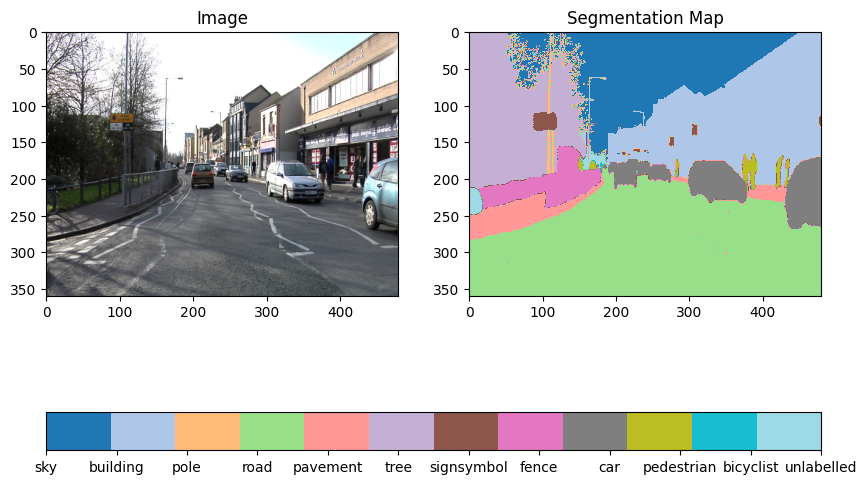

In [47]:
# prompt: I wanrt to plot img and segmentation_map close to each other. They should have the same dimension. segmentation_map should be colored and have a legend just like in plot_segmentation_map function. If it is possible the legend should be under he two images.

import matplotlib.pyplot as plt
import numpy as np

n_classes = len(id2label)
cmap = plt.get_cmap('tab20', n_classes)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

# Plot the image on the left
ax1.imshow(img)
ax1.set_title("Image")

# Plot the segmentation map on the right
segmentation_plot = ax2.imshow(segmentation_map, cmap=cmap)
ax2.set_title("Segmentation Map")

# Add a legend below the two images
cbar = fig.colorbar(segmentation_plot, ax=[ax1, ax2], orientation="horizontal", ticks=np.arange(n_classes))
cbar.ax.set_xticklabels([id2label[i] for i in range(n_classes)])

plt.show()
